In [114]:
%load_ext autoreload
%autoreload 2

import os
import re
from typing import List, Optional, Tuple, Union

import click
import dnnlib
import imageio
import numpy as np
import scipy.interpolate
import torch
from tqdm import tqdm
import mrcfile
import matplotlib.pyplot as plt
from PIL import Image

import legacy

from camera_utils import LookAtPoseSampler
from torch_utils import misc
from pathlib import Path

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
network_pkl = 'pti_out/easy-khair-180-gpc0.8-trans10-025000.pkl/fintuned_generator.pkl'
latent = 'pti_out/easy-khair-180-gpc0.8-trans10-025000.pkl/projected_w.npz'
output = 'pti_out/easy-khair-180-gpc0.8-trans10-025000.pkl/PTI_render/post.mp4'
grid = (1, 1)
kind = 'cubic'
num_keyframes = None
w_frames = 240
truncation_psi = 1
truncation_cutoff = 14
reload_modules = False
cfg = "Head"
image_mode = "image"
sampling_multiplier = 1
nrr = None
gen_shapes = True
output_ply = True
interpolate = True
wraps = 2
video_kwargs = {}
psi = 1

# Init

In [116]:
device = torch.device('cuda:0')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

In [117]:
G.rendering_kwargs['depth_resolution'] = int(G.rendering_kwargs['depth_resolution'] * sampling_multiplier)
G.rendering_kwargs['depth_resolution_importance'] = int(G.rendering_kwargs['depth_resolution_importance'] * sampling_multiplier)
if nrr is not None: G.neural_rendering_resolution = nrr

if truncation_cutoff == 0:
    truncation_psi = 1.0 # truncation cutoff of 0 means no truncation anyways
if truncation_psi == 1.0:
    truncation_cutoff = 14 # no truncation so doesn't matter where we cutoff

ws = torch.tensor(np.load(latent)['w']).to(device)

# Video generation

In [118]:
grid_w = grid[0]
grid_h = grid[1]

if num_keyframes is None:
    if len(ws) % (grid_w*grid_h) != 0:
        raise ValueError('Number of input seeds must be divisible by grid W*H')
    num_keyframes = len(ws) // (grid_w*grid_h)

camera_lookat_point = torch.tensor([0, 0, 0.2], device=device) if cfg == 'FFHQ' else torch.tensor([0, 0, 0], device=device)

cam2world_pose = LookAtPoseSampler.sample(3.14/2, 3.14/2, camera_lookat_point, radius=2.7, device=device)
intrinsics = torch.tensor([[4.2647, 0, 0.5], [0, 4.2647, 0.5], [0, 0, 1]], device=device)
c = torch.cat([cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)
c = c.repeat(len(ws), 1)
# ws = G.mapping(z=zs, c=c, truncation_psi=psi, truncation_cutoff=truncation_cutoff)
# _ = G.synthesis(ws[:1], c[:1]) # warm up
ws = ws.reshape(grid_h, grid_w, num_keyframes, *ws.shape[1:])

In [119]:
def create_samples(N=256, voxel_origin=[0, 0, 0], cube_length=2.0):
    # NOTE: the voxel_origin is actually the (bottom, left, down) corner, not the middle
    voxel_origin = np.array(voxel_origin) - cube_length/2
    voxel_size = cube_length / (N - 1)

    samples = torch.stack(torch.meshgrid(
        torch.arange(0, N, dtype=torch.float32),
        torch.arange(0, N, dtype=torch.float32),
        torch.arange(0, N, dtype=torch.float32),
    ), dim=-1).view(-1, 3)

    # transform first 3 columns
    # to be the x, y, z coordinate
    samples = samples * voxel_size + voxel_origin

    return samples.unsqueeze(0).float(), voxel_origin, voxel_size

In [120]:
# create new folder
mp4 = output
outdirs = os.path.dirname(mp4)
os.makedirs(outdirs, exist_ok=True)

# Render video.
max_batch = 10000000
voxel_resolution = 64
video_out = imageio.get_writer(mp4, mode='I', fps=60, codec='libx264', **video_kwargs)

w = ws[0, 0, 0]

In [126]:
# generate shapes
samples, voxel_origin, voxel_size = create_samples(N=voxel_resolution, voxel_origin=[0, 0, 0], cube_length=G.rendering_kwargs['box_warp'])
samples = samples.to(device)
sigmas = torch.zeros((samples.shape[0], samples.shape[1], 1), device=device)
rgbs = torch.zeros((samples.shape[0], samples.shape[1], 32), device=device)
transformed_ray_directions_expanded = torch.zeros((samples.shape[0], max_batch, 3), device=device)
transformed_ray_directions_expanded[..., -1] = -1

head = 0
with tqdm(total = samples.shape[1]) as pbar:
    with torch.no_grad():
        while head < samples.shape[1]:
            torch.manual_seed(0)
            res = G.sample_mixed(samples[:, head:head+max_batch], transformed_ray_directions_expanded[:, :samples.shape[1]-head], w.unsqueeze(0), truncation_psi=psi, noise_mode='const')
            sigma = res['sigma']
            rgb = res['rgb']
            sigmas[:, head:head+max_batch] = sigma
            rgbs[:, head:head+max_batch] = rgb
            head += max_batch
            pbar.update(max_batch)

sigmas = sigmas.reshape((voxel_resolution, voxel_resolution, voxel_resolution)).cpu().numpy()
rgbs = rgbs.reshape((voxel_resolution, voxel_resolution, voxel_resolution, 32)).cpu().numpy()
sigmas = np.flip(sigmas, 0)
rgbs = np.flip(rgbs, 0)

pad = int(30 * voxel_resolution / 256)
pad_top = int(38 * voxel_resolution / 256)
sigmas[:pad] = 0
sigmas[-pad:] = 0
sigmas[:, :pad] = 0
sigmas[:, -pad_top:] = 0
sigmas[:, :, :pad] = 0
sigmas[:, :, -pad:] = 0

10000000it [00:00, 161598452.71it/s]                                                                                                               


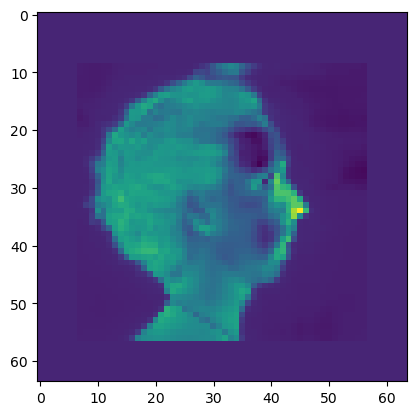

In [127]:
plt.imshow(sigmas[31][::-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


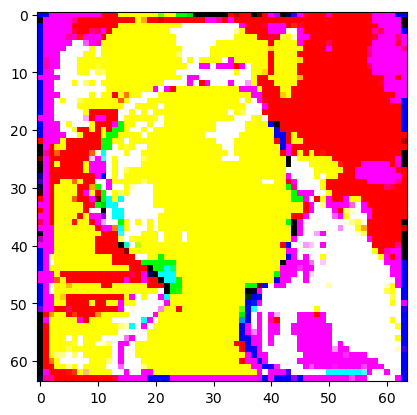

In [128]:
plt.imshow(rgbs[31, ::-1, :, :3])

In [ ]:
from shape_utils import convert_sdf_samples_to_ply, convert_sdf_samples_to_obj
def _color_lambda(x):
    dirs = torch.zeros_like(x)
    dirs[..., -1] = -1
    rgb_feat = G.sample_mixed(x[None], dirs[None], w.unsqueeze(0), truncation_psi=psi, noise_mode='const')['rgb']# [1, N, 32]
    if G.decoder.activation == "sigmoid":
        rgb_feat = rgb_feat * 2 - 1 # Scale to (-1, 1), taken from ray marcher
    # return rgb_feat[..., :3][0]
    # print("rgb_feat.min", rgb_feat.min(), "rgb_feat.max", rgb_feat.max(), "rgb_feat.mean", rgb_feat.mean())
    rgb = G.torgb(rgb_feat.permute(0, 2, 1)[..., None], w[None, -1], fused_modconv=False)[0, ..., 0].to(torch.float32).contiguous().T
    rgb = (rgb * 0.5 + 0.5).clip(0.0, 1.0)
    # rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
    print("x.min", x.min(), "x.max", x.max(), "x.mean", x.mean())
    print("rgb.min", rgb.min(), "rgb.max", rgb.max(), "rgb.mean", rgb.mean())
    return rgb
convert_sdf_samples_to_obj(
    # np.transpose(sigmas, (2, 1, 0)), 
    sigmas,
    path=mp4.replace('.mp4', '') + '_mesh10', 
    level=10, 
    color_lambda=_color_lambda, 
)

In [112]:
G.rendering_kwargs['box_warp']

1

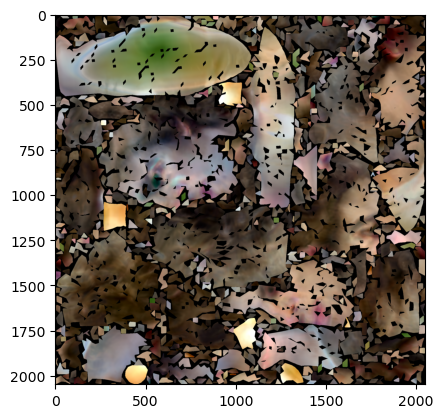

In [113]:
img = np.asarray(Image.open(Path(output).parent / "post_mesh" / "albedo.png"))
plt.imshow(img)